# Argumentative Topology: Finding Loop (holes) in Logic
https://arxiv.org/pdf/2011.08952.pdf 

"Advances in natural language processing have resulted in increased capabilities with respect to multiple tasks. One of the possible causes of the observed performance gains is the introduction of increasingly sophisticated text representations. While many of the new word embedding techniques can be shown to capture particular notions of sentiment or associative structures, we explore the ability of two different word embeddings to uncover or capture the notion of logical shape in text. To this end we present a novel framework that we call Topological Word Embeddings which leverages mathematical techniques in dynamical system analysis and data driven shape extraction (i.e. topological data analysis). In this preliminary work we show that using a topological delay embedding we are able to capture and extract a different, shape-based notion of logic aimed at answering the question “Can we find a circle in a circular argument?”

We will also need to pay attention to time-delayed embeddings, based on this source: 
*  https://www.kaggle.com/tigurius/introduction-to-taken-s-embedding?

Note: Gudhi could perhaps be an alternative
*  https://gudhi.inria.fr/python/latest/_modules/gudhi/point_cloud/timedelay.html -- 

---

**How are we gonna do it?** In a few steps (*after installing all the preliminaries, including the embeddings*):

1.  *Experiment 1*: Persistent homology on plain embeddings 
2.  *Experiment 2*: Persistent homology with Taken's embeddings

### Ripser and Python - Installation 

In [5]:
import zipfile
import tarfile
import os

import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

from ripser import ripser
from persim import plot_diagrams

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine as cosd

from multiprocess import Pool

import warnings
warnings.filterwarnings('ignore')

time: 78 ms (started: 2021-04-28 19:53:12 -04:00)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shahv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Time-delayed embeddings -- Definition 
Source: https://www.kaggle.com/tigurius/introduction-to-taken-s-embedding

In this experiment we ignore the process of finding the parameters of takensEmbeddings, instead we will take the parameters from the paper "Argumentative Topology: Finding Loop(holes) in Logic" p.3. Section 2.3.

*   delay = 2
*   dimension = 2 


In [ ]:
def takensEmbedding(data, delay, dimension):
    """Returns the Takens embedding of data with delay into dimension, delay*dimension must be < len(data)"""
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embeddedData

time: 4.95 ms (started: 2021-02-01 16:02:08 +00:00)


## Loading Data and Embeddings from Google Drive

https://nlp.stanford.edu/projects/glove/

In [ ]:
#You need to mount the google drive; here as /gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive
time: 31.7 s (started: 2021-02-01 16:02:08 +00:00)


In [ ]:
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Jan 20 17:27 .
drwxr-xr-x 1 root root 4096 Feb  1 16:02 ..
drwxr-xr-x 1 root root 4096 Jan 28 17:15 .config
drwxr-xr-x 1 root root 4096 Jan 20 17:27 sample_data
time: 129 ms (started: 2021-02-01 16:02:40 +00:00)


In [ ]:
#looking at the contents
#you need to change these paths to your own 
!ls /gdrive/My\ Drive/Colab\ Notebooks/TopologyMoviesRipser/TDA-Tutorial/IEEE_TDA_Tutorial_Data

!ls -lah /gdrive/My\ Drive/Colab\ Notebooks/TopologyMoviesRipser/TDA-Tutorial/IEEE_TDA_Tutorial_Data/glove.6B/
#!ls -lah /gdrive/My\ Drive/Colab\ Notebooks/TopologyMoviesRipser/TDA-Tutorial/IEEE_TDA_Tutorial_Data/ACL_IMDB/


ACL_IMDB      imdb_reviews_50_250	     ph_emb_features.50.16K.p
glove.6B      imdb_reviews_50_250_train.csv  ph_emb_features.p
glove.6B.zip  ph_emb_features.100.16K.p      raw_data_copy
total 2.1G
-rw------- 1 root root 332M Nov 12 19:22 glove.6B.100d.txt
-rw------- 1 root root 662M Nov 12 19:22 glove.6B.200d.txt
-rw------- 1 root root 990M Nov 12 19:22 glove.6B.300d.txt
-rw------- 1 root root 164M Nov 12 19:22 glove.6B.50d.txt
time: 6.36 s (started: 2021-02-01 16:02:40 +00:00)


In [ ]:
!cp /gdrive/My\ Drive/Colab\ Notebooks/TopologyMoviesRipser/CircularSentences.txt ./

!cat ./CircularSentences.txt

There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.
There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.
There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.
There is no way they can win if they have enough support. They have enough support because there is no way they can win.
time: 432 ms (started: 2021-02-01 16:02:46 +00:00)


In [ ]:
#getting the Glove data; we copy because bandwidth is expensive; 
!cp /gdrive/My\ Drive/Colab\ Notebooks/TopologyMoviesRipser/TDA-Tutorial/IEEE_TDA_Tutorial_Data/glove.6B/glove.6B.50d.txt ./
!cp /gdrive/My\ Drive/Colab\ Notebooks/TopologyMoviesRipser/TDA-Tutorial/IEEE_TDA_Tutorial_Data/glove.6B/glove.6B.100d.txt ./
!cp /gdrive/My\ Drive/Colab\ Notebooks/TopologyMoviesRipser/TDA-Tutorial/IEEE_TDA_Tutorial_Data/glove.6B/glove.6B.200d.txt ./
!cp /gdrive/My\ Drive/Colab\ Notebooks/TopologyMoviesRipser/TDA-Tutorial/IEEE_TDA_Tutorial_Data/glove.6B/glove.6B.300d.txt ./

time: 28.5 s (started: 2021-02-01 16:06:32 +00:00)


In [ ]:
!rm -r *.png
%ls ./

rm: cannot remove '*.png': No such file or directory
CircularSentences.txt  glove.6B.200d.txt  glove.6B.50d.txt
glove.6B.100d.txt      glove.6B.300d.txt  sample_data/
time: 235 ms (started: 2021-02-01 16:07:01 +00:00)


# Preparing the data

*   We need a mapping from words to vectors
*   We need to vectorize the CircularSentences using this mapping 



In [ ]:
# getting Glove words and their vectors for all three models 
# (Brute force, to be cleaned at some point, perhaps. But makes everything explicit)
gloveModel50 = {}
gloveModel100 = {}
gloveModel200 = {}
gloveModel300 = {}

glove_data50 = './glove.6B.50d.txt'
glove_data100 = './glove.6B.100d.txt'
glove_data200 = './glove.6B.200d.txt'
glove_data300 = './glove.6B.300d.txt'

f = open(glove_data50, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    gloveModel50[word] = coefs
f.close()


f = open(glove_data100, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    gloveModel100[word] = coefs
f.close()

f = open(glove_data200, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    gloveModel200[word] = coefs
f.close()

f = open(glove_data300, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    gloveModel300[word] = coefs
f.close()

time: 1min (started: 2021-02-01 16:07:01 +00:00)


In [ ]:
with open('./CircularSentences.txt', 'r') as f:
  sents = f.readlines()

print(sents[0:4])

['There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.\n', 'There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.\n', 'There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.\n', 'There is no way they can win if they have enough support. They have enough support because there is no way they can win.\n']
time: 9.2 ms (started: 2021-02-01 16:08:02 +00:00)


In [ ]:
print(type(sents))

## Tokenizing and retrieving GloVe values 

(for each observation)

In [ ]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+|[,.]')
tokenized_sents = [tokenizer.tokenize(i.lower()) for i in sents]

print(tokenized_sents[0])

['there', 'is', 'no', 'way', 'they', 'can', 'win', 'if', 'they', 'do', 'not', 'have', 'enough', 'support', '.', 'they', 'do', 'not', 'have', 'enough', 'support', ',', 'so', 'there', 'is', 'no', 'way', 'they', 'can', 'win', '.']
time: 5.24 ms (started: 2021-02-01 16:08:02 +00:00)


In [ ]:
def glove_function(gloveModel ,tokens):
    emb = []
    ok_indices = list(np.where([token in gloveModel.keys() for token in tokens])[0])
    emb = [list(gloveModel[tokens[i]]) for i in ok_indices]
    return(np.asarray(emb))

time: 5.56 ms (started: 2021-02-01 16:08:02 +00:00)


In [ ]:
glove_function(gloveModel100,'.')

In [ ]:
glove_sents50 = [glove_function(gloveModel50, i) for i in tokenized_sents]
glove_sents100 = [glove_function(gloveModel100, i) for i in tokenized_sents]
glove_sents200 = [glove_function(gloveModel200, i) for i in tokenized_sents]
glove_sents300 = [glove_function(gloveModel300, i) for i in tokenized_sents]

time: 30.7 ms (started: 2021-02-01 16:08:02 +00:00)


## An example of Glove representation 

(the first observation)

In [ ]:
print('Looking at the GloVe representation as a matrix', glove_sents100[0].shape, '.\n')
glove_sents100[2]

# Experiment 1: Applying persistent homology to the embeddings of CircularSentences

In [ ]:
from google.colab import files # to enable saving images plt.savefig('test.pdf') files.download('test.pdf')

time: 1.25 ms (started: 2021-02-01 16:08:43 +00:00)


In [ ]:
print(glove_sents100[2].shape)
print(np.transpose(glove_sents100[2]).shape)

We have an option either using 30 points with 100 features of 100 points with 30 features:

`ripser(X, ........)`

`X : ndarray (n_samples, n_features)` A numpy array of either data or distance matrix (also pass distance_matrix=True). Can also be a sparse distance matrix of type scipy.sparse

In [ ]:
#dist = lambda x1,x2: np.linalg.norm(x1) * np.linalg.norm(x2) * cosd(x1,x2)

# interestingly enough this measure fails to produce a single H1 dot in the diagram.

### 30 points 100 features 

In [ ]:
for i in range(0,len(glove_sents100)):
  print(sents[i])
  diagrams = ripser(glove_sents100[i], metric='euclidean')['dgms']
  print(type(diagrams))
  ###########################
  #ImageName='30p_100f_noTe'+sents[i]+'.'+'png'
  plot_diagrams(diagrams, show=False)
  #plt.savefig(ImageName) 
  #files.download(ImageName)
  ########################### HERE no need to save as we are not doing embeddings
  plt.show()

### 100 points 30 features

In [ ]:
for i in range(0,len(glove_sents100)):
  print(sents[i])
  diagrams = ripser(np.transpose(glove_sents100[i]), metric='euclidean')['dgms']
  plot_diagrams(diagrams, show=True)
  plt.show()

It seems we only have a bunch of random points in H1. 

# Experiment 2: Applying persistent homology with time-delayed embeddings to Circular Sentences

We will use 

`takensEmbedding (data, delay, dimension):` 

with `delay=2`  and `dimension=2` (per the article)


---
Before we get there here's the process, per cited article (p.3):

"We begin by embedding our text into a word-vector point cloud using a pretrained model, see (a)→(b). 

Next we construct a 1−dimensional time series by projecting each embedded word onto a fixed subspace (i.e. computing the dot product of each word vector in  the text with a fixed random vector), see (b)→(c). 

This one dimensional time series can then be embedded using TDEs and 

the resulting point cloud can be analyzed using persistent homology to yield a persistence diagram, see (c)→(e). "


### Quick look at the data (not very illuminating at this point)



*   I don't understand what is happening with dimensions here, in both cases.
*   Why is dimensionality reduced by 4 



In [ ]:
print(glove_sents100[3].shape)
te=takensEmbedding(glove_sents100[1],2,2)
print(te.shape)
print(te)

In [ ]:
print(np.transpose(glove_sents100[1]).shape)
te=takensEmbedding(np.transpose(glove_sents100[1]),2,2)
print(te.shape)
print(te)

**Note:** A brute force assignment 

`diagrams = ripser(np.transpose(takensEmbedding(glove_sents[i],2,2)), metric=dist)['dgms']`

fails due to dimensionality mismatches; ditto without transpose

In [ ]:
%ls
%rm -r *png

CircularSentences.txt  glove.6B.200d.txt  sample_data/
glove.6B.100d.txt      glove.6B.300d.txt
rm: cannot remove '*png': No such file or directory
time: 247 ms (started: 2021-02-01 16:05:26 +00:00)


## The core of the experiment

In [ ]:
# Step 1. sentences to vectors we already did earlier; we have glove_sents
# Step 2. Get the fixed random vector and create a time series.
#            i.e. "the dot product of each word vector in the text with a fixed random vector"
# Question: why not concatenate the vectors? 

vector_dim50=50
vector_dim100=100 #or whatever is used as embedding
vector_dim200=200 
vector_dim300=300 

#np.random.seed(42)
#np.random.seed(1)
np.random.seed(42)
random_vector50=np.random.random(size=vector_dim50)
random_vector100=np.random.random(size=vector_dim100)
random_vector200=np.random.random(size=vector_dim200)
random_vector300=np.random.random(size=vector_dim300)
# print(random_vector)

#np.dot(glove_sents100[1][2],random_vector100)

def t_series(vectorized_sentence,random_vector):
  prods=[np.dot(word_v,random_vector) for word_v in vectorized_sentence]
  return np.array(prods)

"""
ex=t_series(glove_sents100[1],random_vector100)
print(ex.shape)
print(ex)
"""

'\nex=t_series(glove_sents100[1],random_vector100)\nprint(ex.shape)\nprint(ex)\n'

time: 10.7 ms (started: 2021-02-01 17:59:34 +00:00)


In [ ]:
# Why doesn't transpose change takens embeddigns? Because we have a 1 dimensional time series,
# and apparently the input can be vector or vector.T 
print(takensEmbedding(t_series(glove_sents100[1],random_vector100),2,2).shape)
print(takensEmbedding(np.transpose(t_series(glove_sents100[1], random_vector100)),2,2).shape)

te1 = takensEmbedding(t_series(glove_sents100[1],random_vector100),2,2)
te1t = takensEmbedding(np.transpose(t_series(glove_sents100[1],random_vector100)),2,2)

print(te1[1][7])
print(te1t[1][7])

print(te1==te1t)

np.abs(np.transpose(te1))

(2, 26)
(2, 26)
-2.8277824225027763
-2.8277824225027763
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]


array([[0.13918563, 1.21024713],
       [2.52684544, 0.53539964],
       [1.21024713, 0.88494511],
       [0.53539964, 0.65483492],
       [0.88494511, 1.91398174],
       [0.65483492, 0.15000177],
       [1.91398174, 0.88494511],
       [0.15000177, 2.82778242],
       [0.88494511, 1.15202998],
       [2.82778242, 1.57573951],
       [1.15202998, 0.54917081],
       [1.57573951, 0.91015652],
       [0.54917081, 0.25902094],
       [0.91015652, 0.88494511],
       [0.25902094, 2.82778242],
       [0.88494511, 1.15202998],
       [2.82778242, 1.57573951],
       [1.15202998, 0.54917081],
       [1.57573951, 0.91015652],
       [0.54917081, 0.15000177],
       [0.91015652, 0.13918563],
       [0.15000177, 2.52684544],
       [0.13918563, 1.21024713],
       [2.52684544, 0.53539964],
       [1.21024713, 0.88494511],
       [0.53539964, 0.65483492]])

time: 16.7 ms (started: 2021-02-01 16:52:32 +00:00)


In [ ]:
plt.plot(te1[0],te1[1],'bo')
plt.show()

In [ ]:
#plt.plot(np.abs(te1[0]),np.abs(te1[1]),'bo')

In [ ]:
#%ls -lth
""" we misunderstood repr() so we won't use it
print(len(random_vector100))
f"{repr(glove_sents100)}"[0:]
"""


In [ ]:
# Step 3 and 4 apply embeddings and visualize persistent homology 

# this doesn't work well for negative values 
def do_ripser(glove_sents,random_vector):
  for i in range(0,len(glove_sents)):
    print(sents[i])
    diagrams = ripser(np.transpose(takensEmbedding(t_series(glove_sents[i],random_vector),2,2)), metric='euclidean')['dgms']
    plot_diagrams(diagrams, show=False)
    ImageName=str(len(random_vector))+'te'+sents[i]+'.'+'png'
    plt.savefig(ImageName) 
    files.download(ImageName)
    plt.show()



time: 4.38 ms (started: 2021-02-01 17:59:46 +00:00)


There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

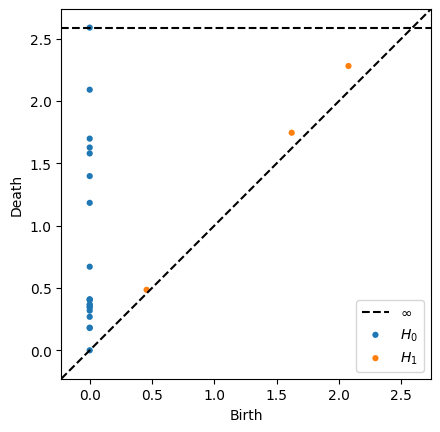

There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

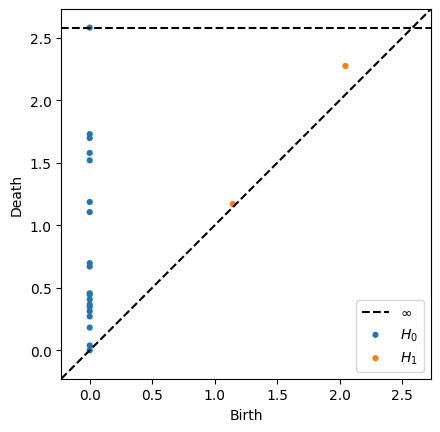

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

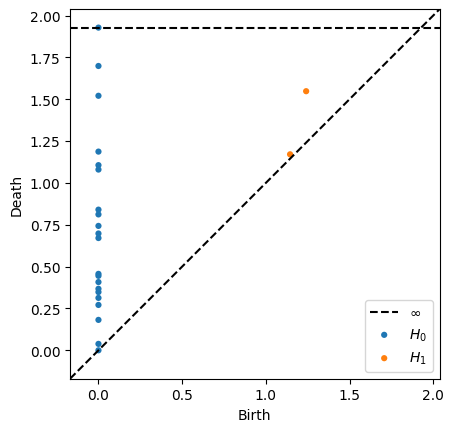

There is no way they can win if they have enough support. They have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

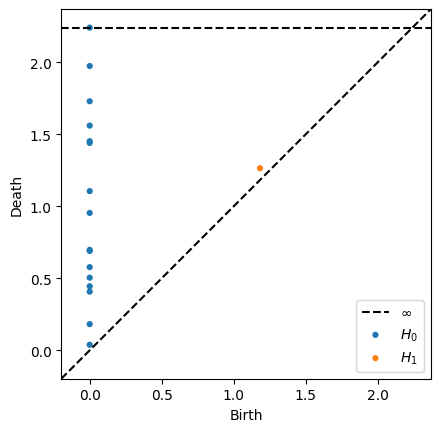

time: 1.43 s (started: 2021-02-01 17:13:49 +00:00)


In [ ]:
do_ripser(glove_sents50,random_vector50)

There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

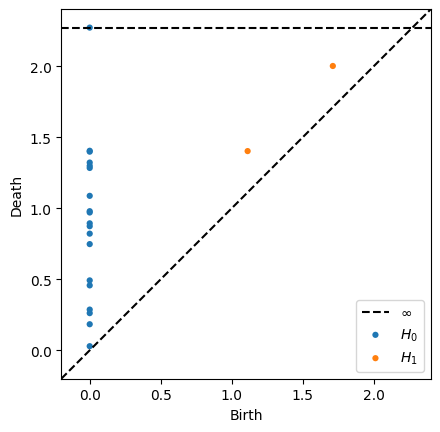

There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

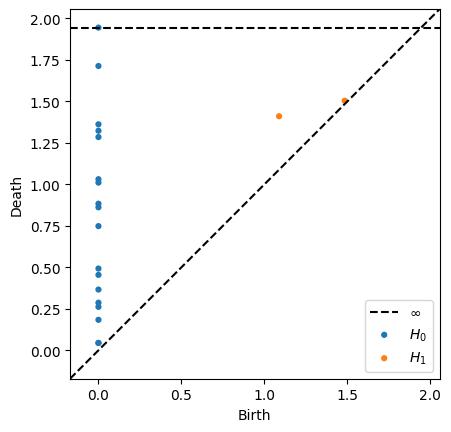

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

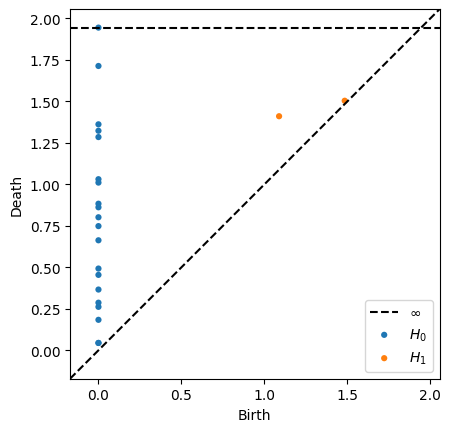

There is no way they can win if they have enough support. They have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

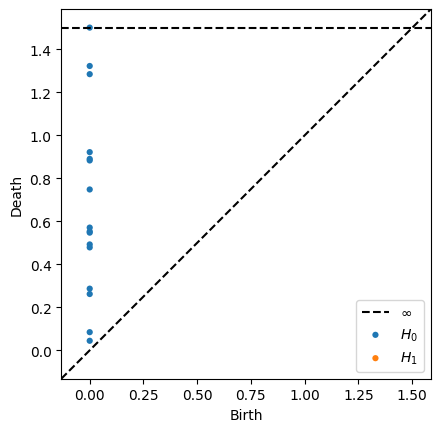

time: 1.58 s (started: 2021-02-01 17:14:17 +00:00)


In [ ]:
do_ripser(glove_sents100,random_vector100)

There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

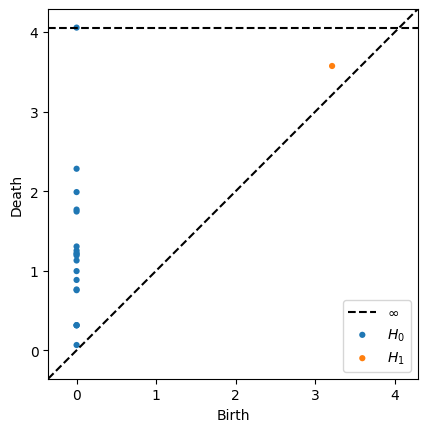

There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

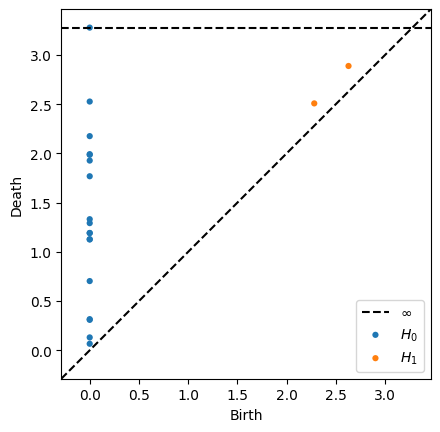

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

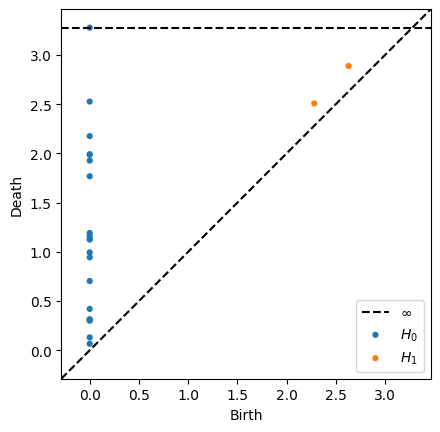

There is no way they can win if they have enough support. They have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

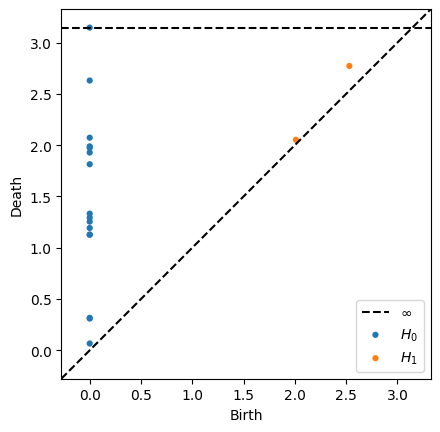

time: 1.48 s (started: 2021-02-01 17:08:57 +00:00)


In [ ]:
do_ripser(glove_sents200,random_vector200)


There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

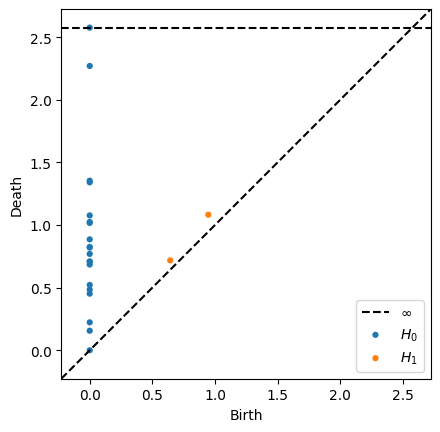

There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

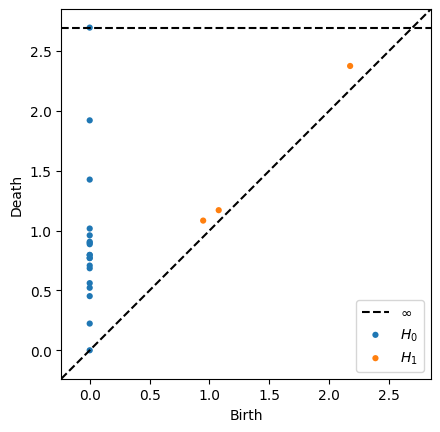

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

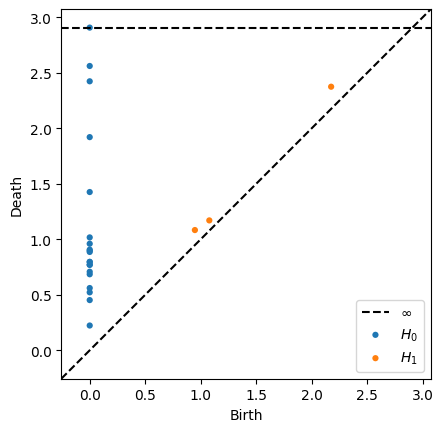

There is no way they can win if they have enough support. They have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

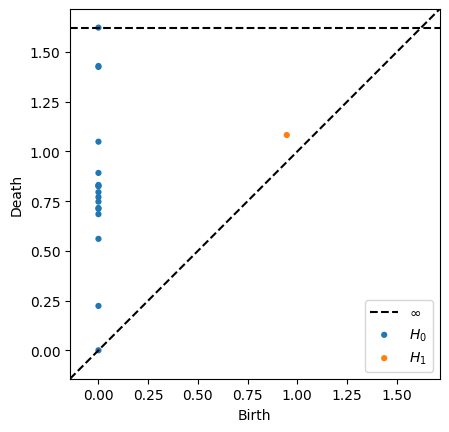

time: 1.41 s (started: 2021-02-01 17:12:07 +00:00)


In [ ]:
do_ripser(glove_sents300,random_vector300)

In [ ]:
# Step 3 and 4 apply embeddings and visualize persistent homology 

# this doesn't work well for negative values, hence the abs() 

def do_ripser_a(glove_sents,random_vector):
  for i in range(0,len(glove_sents)):
    print(sents[i])
    te=np.transpose(takensEmbedding(t_series(glove_sents[i],random_vector),2,2))
    te=abs(te)
    diagrams = ripser(te, metric='euclidean')['dgms']
    plot_diagrams(diagrams, show=False)
    ImageName='a'+str(len(random_vector))+'te'+sents[i]+'.'+'png'
    plt.savefig(ImageName) 
    files.download(ImageName)
    plt.show()




time: 7.49 ms (started: 2021-02-01 17:59:57 +00:00)


There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

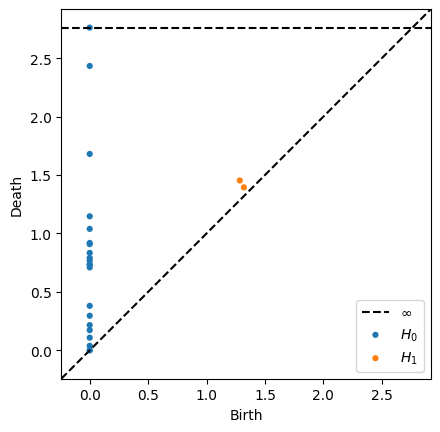

There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

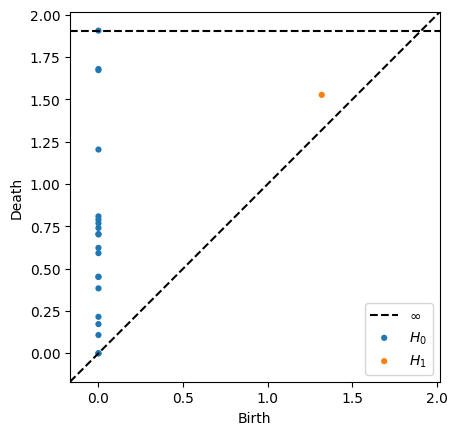

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

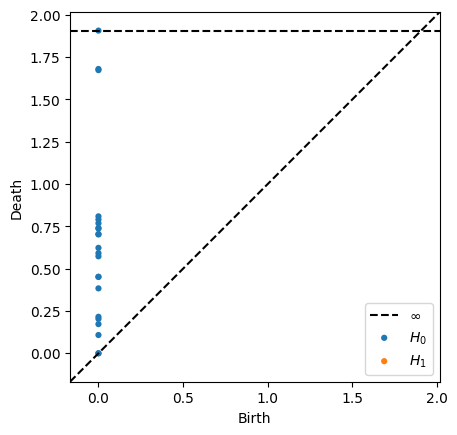

There is no way they can win if they have enough support. They have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

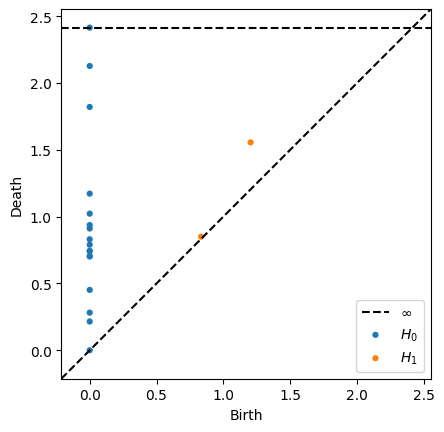

time: 1.46 s (started: 2021-02-01 18:00:01 +00:00)


In [ ]:
do_ripser_a(glove_sents50,random_vector50)


There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

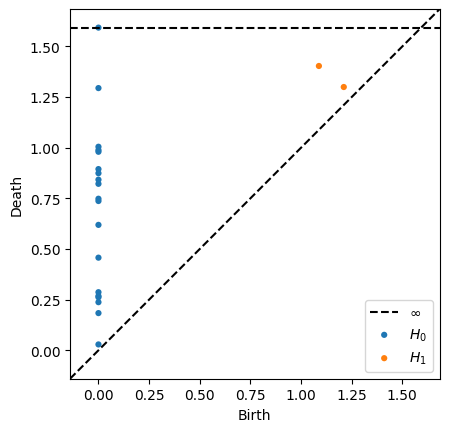

There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

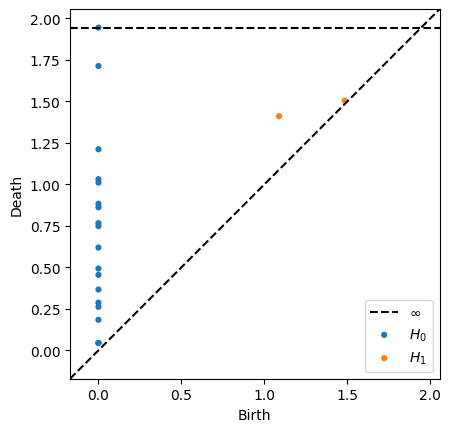

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

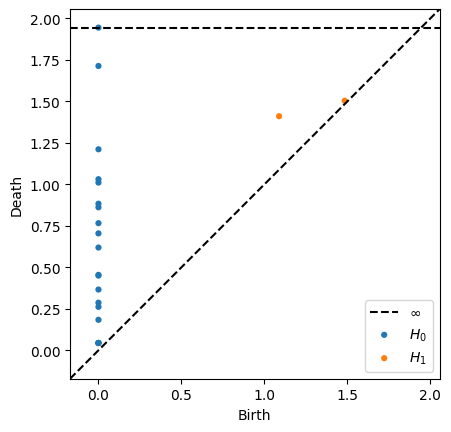

There is no way they can win if they have enough support. They have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

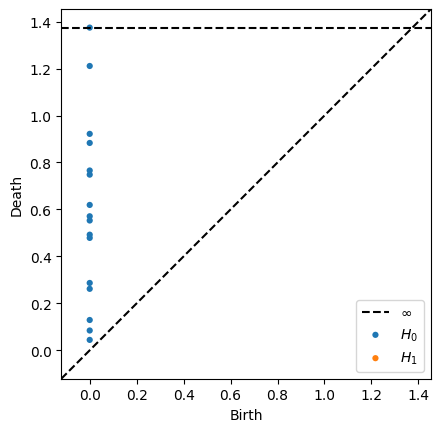

time: 1.55 s (started: 2021-02-01 17:17:46 +00:00)


In [ ]:
do_ripser_a(glove_sents100,random_vector100)


There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

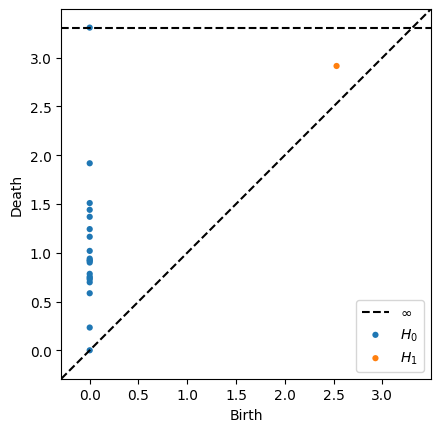

There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

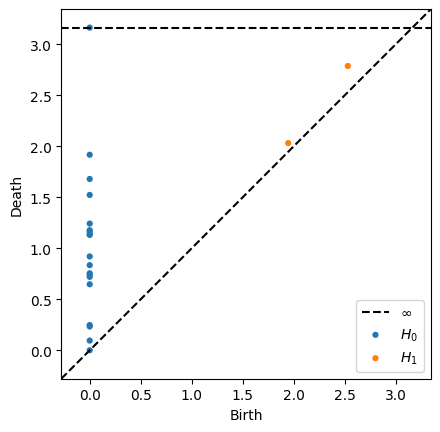

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

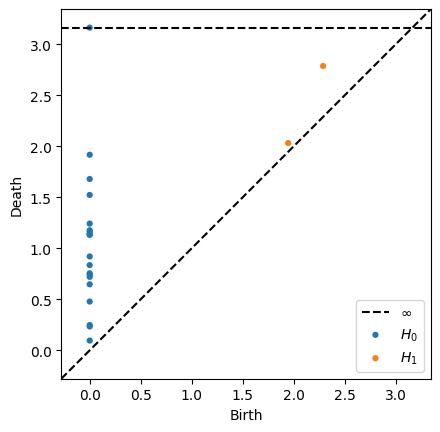

There is no way they can win if they have enough support. They have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

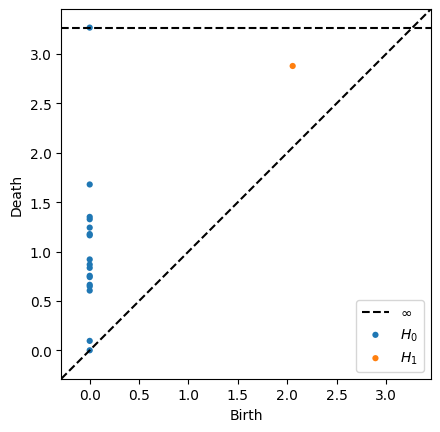

time: 1.54 s (started: 2021-02-01 18:00:21 +00:00)


In [ ]:
do_ripser_a(glove_sents200,random_vector200)


There is no way they can win if they do not have enough support. They do not have enough support, so there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

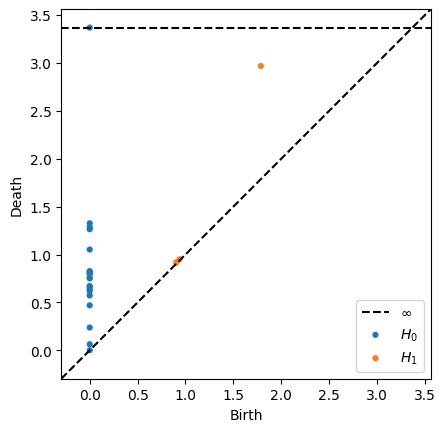

There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

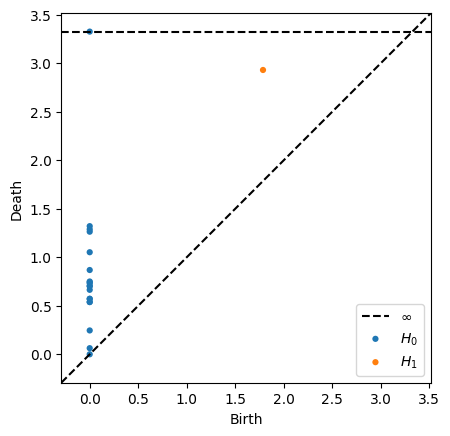

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

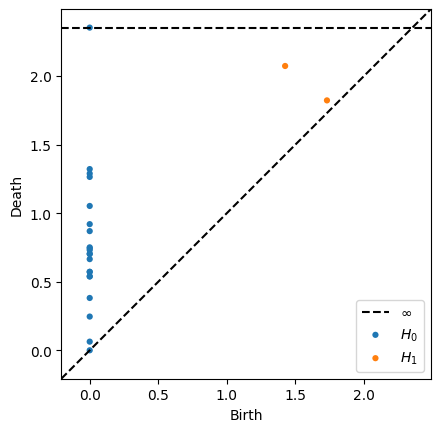

There is no way they can win if they have enough support. They have enough support because there is no way they can win.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

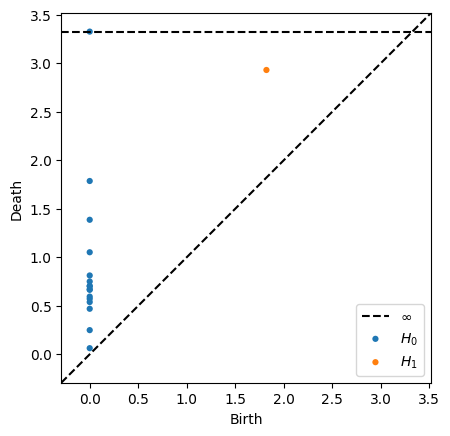

time: 1.48 s (started: 2021-02-01 17:18:46 +00:00)


In [ ]:
do_ripser_a(glove_sents300,random_vector300)

# Interactive exploration 

Here you can input your own sentence and see its diagram 

In [ ]:
def display_argument(sentences,vector):
  tokenized_sents = tokenizer.tokenize(sentences.lower()) 
  if len(vector)==50:
    glove_sents = glove_function(gloveModel50,tokenized_sents)
  if len(vector)==100:
    glove_sents = glove_function(gloveModel100,tokenized_sents)
  if len(vector)==200:
    glove_sents = glove_function(gloveModel200, tokenized_sents)
  if len(vector)==300:
    glove_sents = glove_function(gloveModel300,tokenized_sents)
  print(sentences)
  print(tokenized_sents)
  te=np.transpose(takensEmbedding(t_series(glove_sents,vector),2,2))
  te=abs(te)
  diagrams = ripser(te, metric='euclidean')['dgms']
  plot_diagrams(diagrams, show=False)
  ImageName='i' + str(len(vector)) + 'tde_abs'+sentences+'.'+'png'
  plt.savefig(ImageName) 
  files.download(ImageName)
  plt.show()




time: 11.9 ms (started: 2021-02-01 17:29:12 +00:00)


There is no way for the team to win because the team does not have bad players. There is no way for the team to win because the team does not have bad players.
['there', 'is', 'no', 'way', 'for', 'the', 'team', 'to', 'win', 'because', 'the', 'team', 'does', 'not', 'have', 'bad', 'players', '.', 'there', 'is', 'no', 'way', 'for', 'the', 'team', 'to', 'win', 'because', 'the', 'team', 'does', 'not', 'have', 'bad', 'players', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

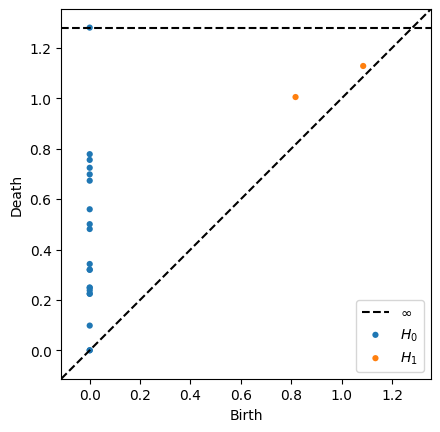

There is no way for the team to win because the team does not have bad players. There is no way for the team to win because the team does not have bad players.
['there', 'is', 'no', 'way', 'for', 'the', 'team', 'to', 'win', 'because', 'the', 'team', 'does', 'not', 'have', 'bad', 'players', '.', 'there', 'is', 'no', 'way', 'for', 'the', 'team', 'to', 'win', 'because', 'the', 'team', 'does', 'not', 'have', 'bad', 'players', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

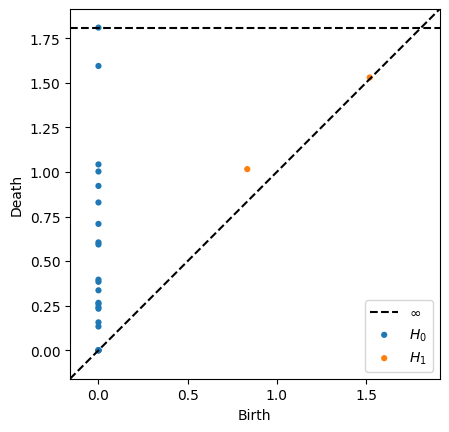

There is no way for the team to win because the team does not have bad players. There is no way for the team to win because the team does not have bad players.
['there', 'is', 'no', 'way', 'for', 'the', 'team', 'to', 'win', 'because', 'the', 'team', 'does', 'not', 'have', 'bad', 'players', '.', 'there', 'is', 'no', 'way', 'for', 'the', 'team', 'to', 'win', 'because', 'the', 'team', 'does', 'not', 'have', 'bad', 'players', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

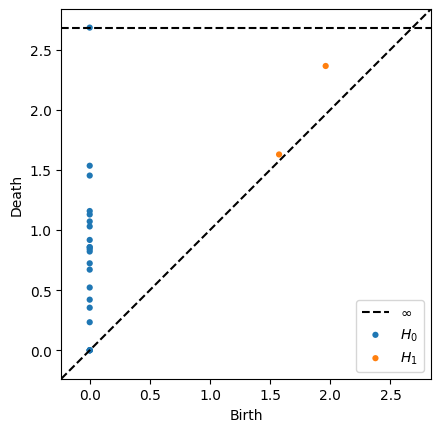

There is no way for the team to win because the team does not have bad players. There is no way for the team to win because the team does not have bad players.
['there', 'is', 'no', 'way', 'for', 'the', 'team', 'to', 'win', 'because', 'the', 'team', 'does', 'not', 'have', 'bad', 'players', '.', 'there', 'is', 'no', 'way', 'for', 'the', 'team', 'to', 'win', 'because', 'the', 'team', 'does', 'not', 'have', 'bad', 'players', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

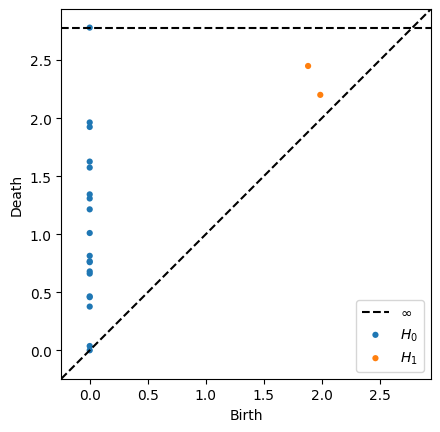

time: 1.45 s (started: 2021-02-01 18:56:23 +00:00)


In [ ]:
# Redundant 
# 
argument='There is no way for the team to win because the team does not have bad players. There is no way for the team to win because the team does not have bad players.'
display_argument(argument,random_vector50)
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

No way the anarchists can lose the primary elections if they have enough support. The anarchists have strong support, so there is no way they can lose the primaries.
['no', 'way', 'the', 'anarchists', 'can', 'lose', 'the', 'primary', 'elections', 'if', 'they', 'have', 'enough', 'support', '.', 'the', 'anarchists', 'have', 'strong', 'support', ',', 'so', 'there', 'is', 'no', 'way', 'they', 'can', 'lose', 'the', 'primaries', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

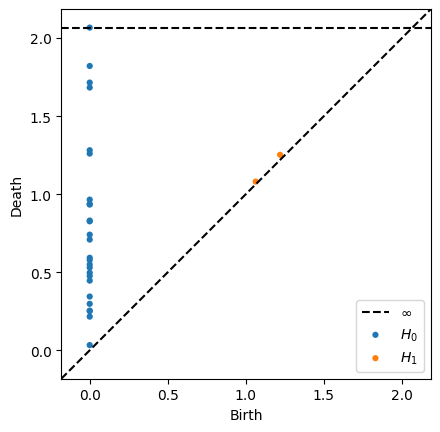

No way the anarchists can lose the primary elections if they have enough support. The anarchists have strong support, so there is no way they can lose the primaries.
['no', 'way', 'the', 'anarchists', 'can', 'lose', 'the', 'primary', 'elections', 'if', 'they', 'have', 'enough', 'support', '.', 'the', 'anarchists', 'have', 'strong', 'support', ',', 'so', 'there', 'is', 'no', 'way', 'they', 'can', 'lose', 'the', 'primaries', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

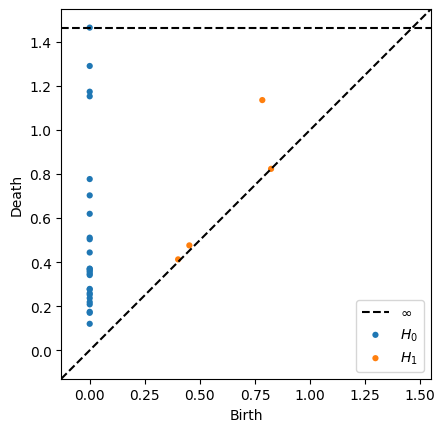

No way the anarchists can lose the primary elections if they have enough support. The anarchists have strong support, so there is no way they can lose the primaries.
['no', 'way', 'the', 'anarchists', 'can', 'lose', 'the', 'primary', 'elections', 'if', 'they', 'have', 'enough', 'support', '.', 'the', 'anarchists', 'have', 'strong', 'support', ',', 'so', 'there', 'is', 'no', 'way', 'they', 'can', 'lose', 'the', 'primaries', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

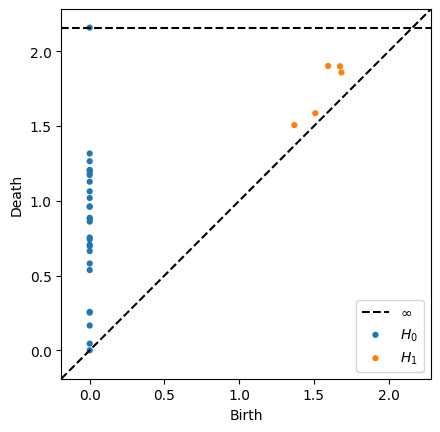

No way the anarchists can lose the primary elections if they have enough support. The anarchists have strong support, so there is no way they can lose the primaries.
['no', 'way', 'the', 'anarchists', 'can', 'lose', 'the', 'primary', 'elections', 'if', 'they', 'have', 'enough', 'support', '.', 'the', 'anarchists', 'have', 'strong', 'support', ',', 'so', 'there', 'is', 'no', 'way', 'they', 'can', 'lose', 'the', 'primaries', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

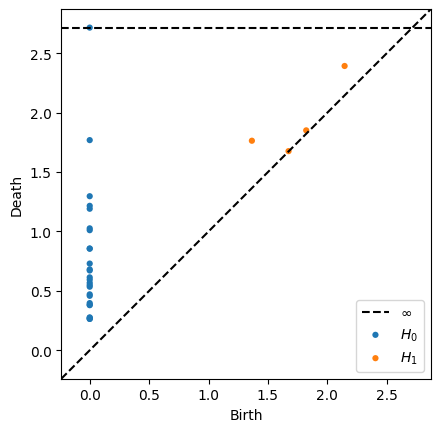

time: 1.51 s (started: 2021-02-01 20:04:23 +00:00)


In [ ]:
# Circular 
# 
argument='There is no way for the crew to lose because the crew does not have bad players. The crew does not have bad players because there is no way for the crew to lose.'

argument='The Russian crew must lose  because the coach did not hire Siberian rowers. The team did not enlist the good Siberian rowers because there is no way for the Russian crew to win.'

#argument='There is no way for the horse to win because the jockey is not trying hard. The jockey is not trying hard because there is no way for the horse to win.'

argument = 'No way the anarchists can lose the primary elections if they have enough support. The anarchists have strong support, so there is no way they can lose the primaries.'
display_argument(argument,random_vector50)
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.
['there', 'is', 'a', 'way', 'they', 'can', 'win', 'because', 'they', 'do', 'not', 'have', 'enough', 'support', '.', 'they', 'do', 'not', 'have', 'enough', 'support', 'because', 'there', 'is', 'no', 'way', 'they', 'can', 'win', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

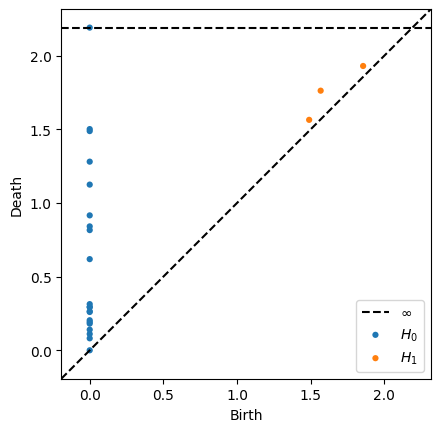

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.
['there', 'is', 'a', 'way', 'they', 'can', 'win', 'because', 'they', 'do', 'not', 'have', 'enough', 'support', '.', 'they', 'do', 'not', 'have', 'enough', 'support', 'because', 'there', 'is', 'no', 'way', 'they', 'can', 'win', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

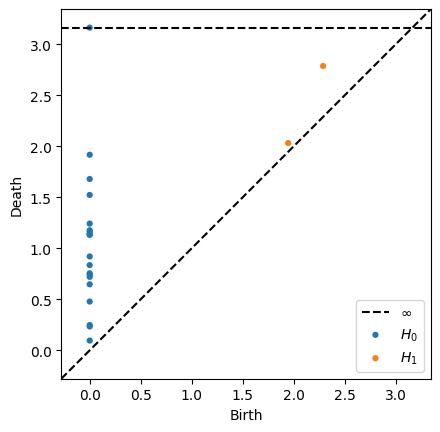

There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.
['there', 'is', 'a', 'way', 'they', 'can', 'win', 'because', 'they', 'do', 'not', 'have', 'enough', 'support', '.', 'they', 'do', 'not', 'have', 'enough', 'support', 'because', 'there', 'is', 'no', 'way', 'they', 'can', 'win', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

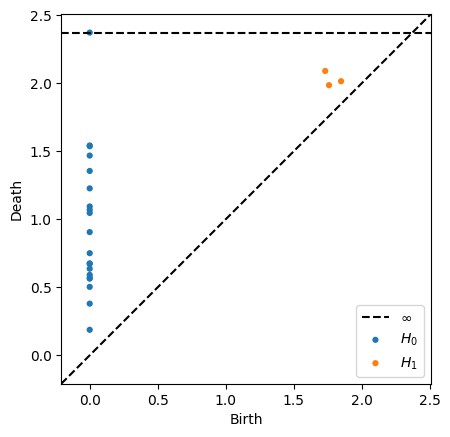

time: 1.07 s (started: 2021-02-01 21:50:06 +00:00)


In [ ]:
# not support =>  win; not win => not support 
# it's not circular, no fallacy, just a convoluted way of saying: 'win'
argument='There is a way they can win because they do not have enough support. They do not have enough support because there is no way they can win.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)


if it rains, it will be wet. if it is wet, it rains
['if', 'it', 'rains', ',', 'it', 'will', 'be', 'wet', '.', 'if', 'it', 'is', 'wet', ',', 'it', 'rains']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

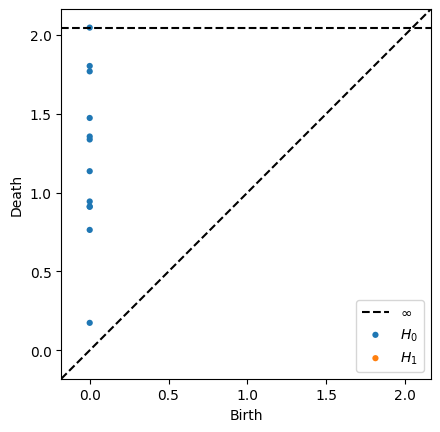

if it rains, it will be wet. if it is wet, it rains
['if', 'it', 'rains', ',', 'it', 'will', 'be', 'wet', '.', 'if', 'it', 'is', 'wet', ',', 'it', 'rains']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

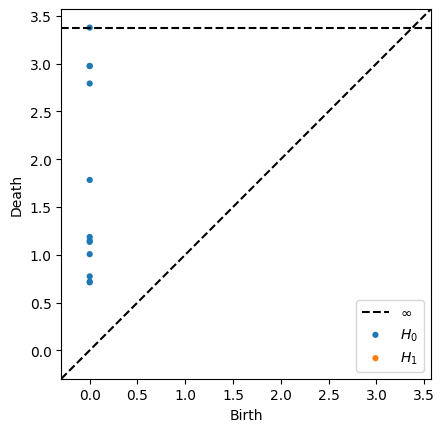

if it rains, it will be wet. if it is wet, it rains
['if', 'it', 'rains', ',', 'it', 'will', 'be', 'wet', '.', 'if', 'it', 'is', 'wet', ',', 'it', 'rains']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

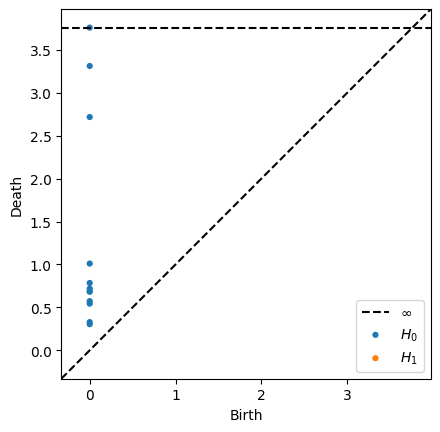

time: 1.34 s (started: 2021-02-01 17:35:51 +00:00)


In [ ]:
#circular: rain=>wet , wet => rains
argument='if it rains, it will be wet. if it is wet, it rains'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

In [ ]:
#not circular: rain=>wet , 
argument='if it rains,snows or thunders, it will be wet. it will be wet, if it thunders, snows or rains'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

mass creates gravity, because dense planets have more gravity. dense planets have more gravity.
['mass', 'creates', 'gravity', ',', 'because', 'dense', 'planets', 'have', 'more', 'gravity', '.', 'dense', 'planets', 'have', 'more', 'gravity', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

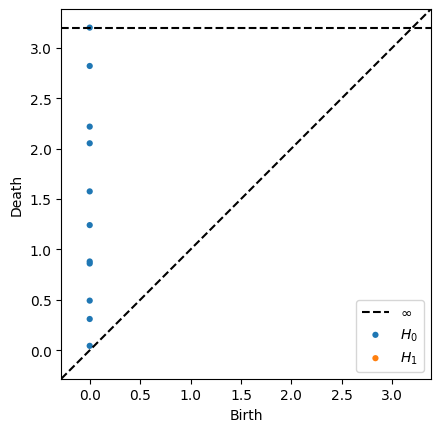

mass creates gravity, because dense planets have more gravity. dense planets have more gravity.
['mass', 'creates', 'gravity', ',', 'because', 'dense', 'planets', 'have', 'more', 'gravity', '.', 'dense', 'planets', 'have', 'more', 'gravity', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

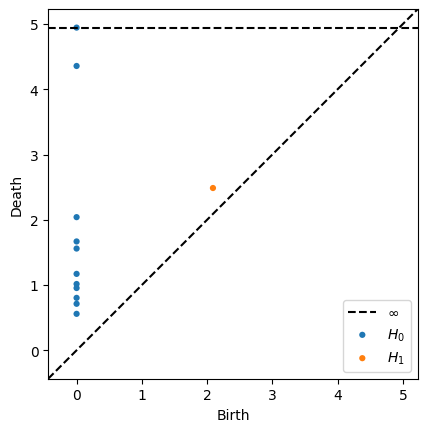

mass creates gravity, because dense planets have more gravity. dense planets have more gravity.
['mass', 'creates', 'gravity', ',', 'because', 'dense', 'planets', 'have', 'more', 'gravity', '.', 'dense', 'planets', 'have', 'more', 'gravity', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

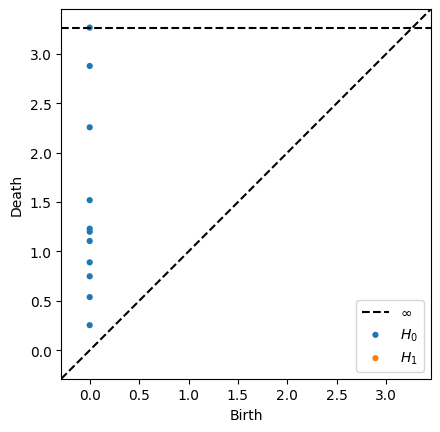

time: 1.11 s (started: 2021-02-01 17:36:25 +00:00)


In [ ]:
#circular: from Dilbert https://dilbert.com/strip/1999-03-01 
argument='mass creates gravity, because dense planets have more gravity. dense planets have more gravity.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

In [ ]:
#circular: from Dilbert https://dilbert.com/strip/1999-03-01 
argument='mass creates gravity, because dense planets have more gravity. more dense planets have more gravity.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

mass creates gravity, because dense planets have more gravity. planets are more dense if they have more gravity.
['mass', 'creates', 'gravity', ',', 'because', 'dense', 'planets', 'have', 'more', 'gravity', '.', 'planets', 'are', 'more', 'dense', 'if', 'they', 'have', 'more', 'gravity', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

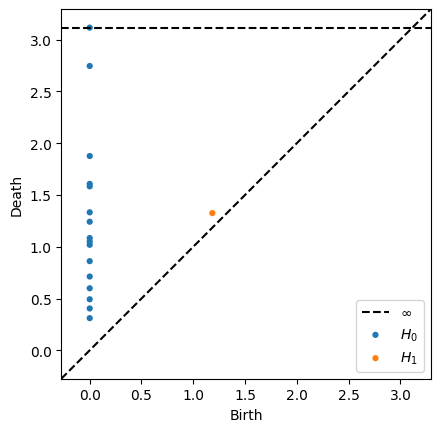

mass creates gravity, because dense planets have more gravity. planets are more dense if they have more gravity.
['mass', 'creates', 'gravity', ',', 'because', 'dense', 'planets', 'have', 'more', 'gravity', '.', 'planets', 'are', 'more', 'dense', 'if', 'they', 'have', 'more', 'gravity', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

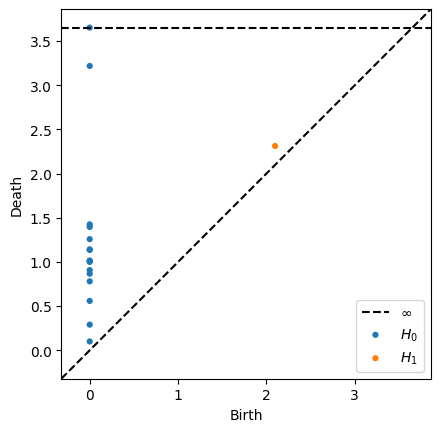

mass creates gravity, because dense planets have more gravity. planets are more dense if they have more gravity.
['mass', 'creates', 'gravity', ',', 'because', 'dense', 'planets', 'have', 'more', 'gravity', '.', 'planets', 'are', 'more', 'dense', 'if', 'they', 'have', 'more', 'gravity', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

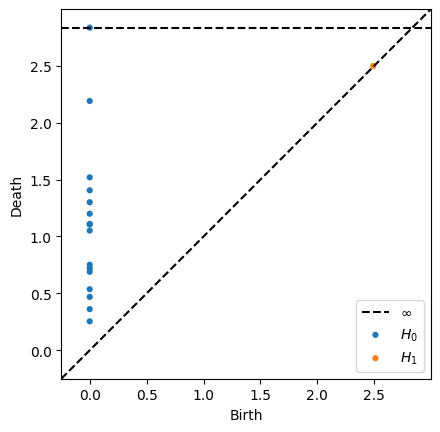

time: 1.21 s (started: 2021-02-01 17:36:49 +00:00)


In [ ]:
#circular: from Dilbert https://dilbert.com/strip/1999-03-01 
argument='mass creates gravity, because dense planets have more gravity. planets are more dense if they have more gravity.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

In [ ]:
#messing up Dilbert https://dilbert.com/strip/1999-03-01 
#
argument='planets have gravity. donkeys are dense because they planets have gravity.'
display_argument(argument)

In [ ]:
#messing up Dilbert https://dilbert.com/strip/1999-03-01 
#
argument='planets have gravity. definitions are dense because the planets have gravity.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

In [ ]:
#messing up Dilbert https://dilbert.com/strip/1999-03-01 
#
argument='planets have gravity. physicians are dense because the planets have gravity.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

In [ ]:
#messing up Dilbert https://dilbert.com/strip/1999-03-01 
#
argument='planets have gravity. nurses are dense because the planets have gravity.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

mass creates electrons, because dense planets have more electrons. planets are more dense if they have more protons.
['mass', 'creates', 'electrons', ',', 'because', 'dense', 'planets', 'have', 'more', 'electrons', '.', 'planets', 'are', 'more', 'dense', 'if', 'they', 'have', 'more', 'protons', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

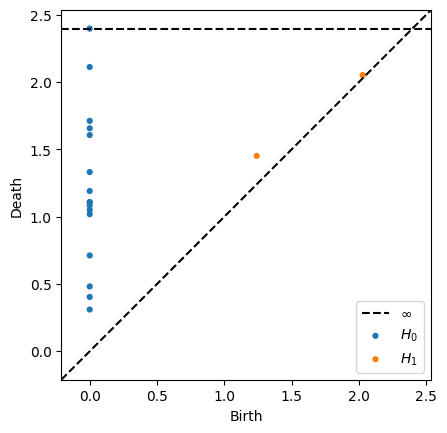

mass creates electrons, because dense planets have more electrons. planets are more dense if they have more protons.
['mass', 'creates', 'electrons', ',', 'because', 'dense', 'planets', 'have', 'more', 'electrons', '.', 'planets', 'are', 'more', 'dense', 'if', 'they', 'have', 'more', 'protons', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

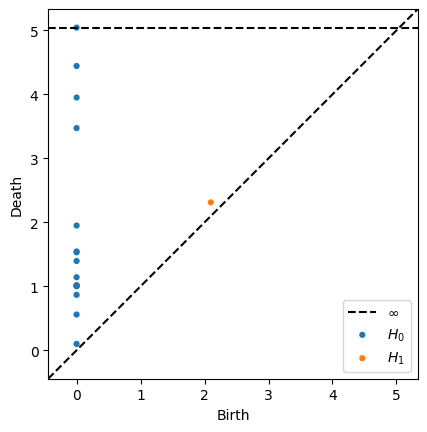

mass creates electrons, because dense planets have more electrons. planets are more dense if they have more protons.
['mass', 'creates', 'electrons', ',', 'because', 'dense', 'planets', 'have', 'more', 'electrons', '.', 'planets', 'are', 'more', 'dense', 'if', 'they', 'have', 'more', 'protons', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

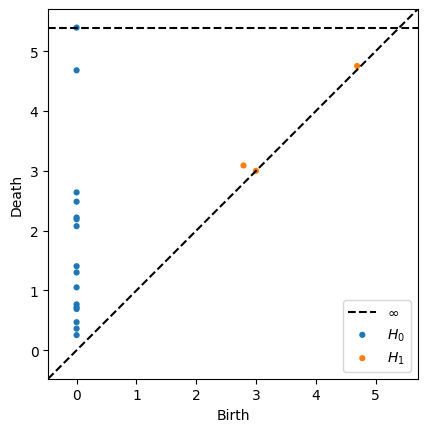

time: 1.32 s (started: 2021-02-01 17:37:23 +00:00)


In [ ]:
#circular: from Dilbert https://dilbert.com/strip/1999-03-01 
argument='mass creates electrons, because dense planets have more electrons. planets are more dense if they have more protons.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

time delay is 2 because we have two sentences? 

projections on random_vector will be similar if the words are similar. 

so, for similar words with opposite meanings we should have the same diagram. 

Circular from the paper: 
“There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.”

In [ ]:
#circular: from the paper  
argument='There is no way they can win because they do not have enough support. They do not have enough support because there is no way they can win.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

In [ ]:
#not circular: modified from the paper 
argument='There is no way they can lose  because they do not have enough support. They do not have enough support because there is no way they can win.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

There is no way they can lose  because they do not have enough support. They do not have enough support because there is no way they can lose.
['there', 'is', 'no', 'way', 'they', 'can', 'lose', 'because', 'they', 'do', 'not', 'have', 'enough', 'support', '.', 'they', 'do', 'not', 'have', 'enough', 'support', 'because', 'there', 'is', 'no', 'way', 'they', 'can', 'lose', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

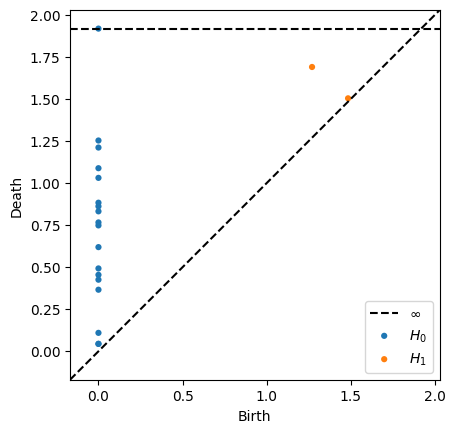

There is no way they can lose  because they do not have enough support. They do not have enough support because there is no way they can lose.
['there', 'is', 'no', 'way', 'they', 'can', 'lose', 'because', 'they', 'do', 'not', 'have', 'enough', 'support', '.', 'they', 'do', 'not', 'have', 'enough', 'support', 'because', 'there', 'is', 'no', 'way', 'they', 'can', 'lose', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

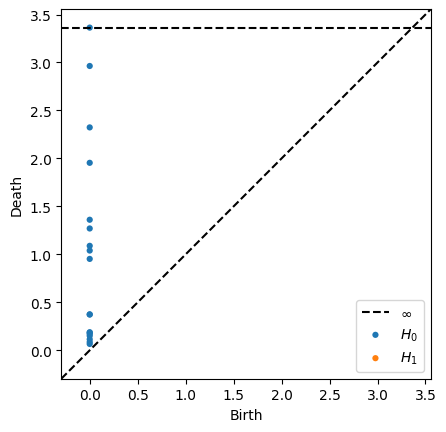

There is no way they can lose  because they do not have enough support. They do not have enough support because there is no way they can lose.
['there', 'is', 'no', 'way', 'they', 'can', 'lose', 'because', 'they', 'do', 'not', 'have', 'enough', 'support', '.', 'they', 'do', 'not', 'have', 'enough', 'support', 'because', 'there', 'is', 'no', 'way', 'they', 'can', 'lose', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

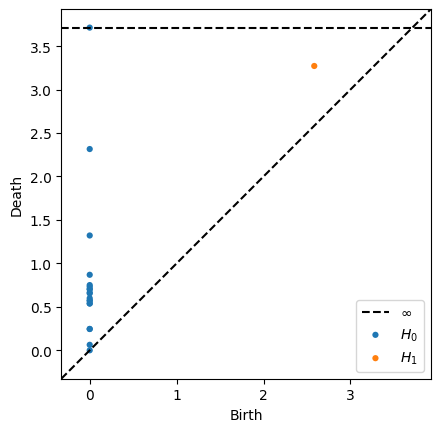

time: 1.21 s (started: 2021-02-01 17:37:41 +00:00)


In [ ]:
#circular: modified from the paper 
argument='There is no way they can lose  because they do not have enough support. They do not have enough support because there is no way they can lose.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

**NEXT **



1.   show that many dots arise from the diversity of words
2.   check the dependence on order 
3.   would syllogisms require time_delay=3?  Every man is mortal. Socrates is a man. Socrates is mortal. 
4.   the picture should be invariant when the words/adjectives are changed
5.   it could help perhaps having positive and negative statements explicitly marked as such. 
6.   what is the topological/Heyting difference between positive and negative, as a representation in vectorial spaces
7.   How are Shervin's embeddings picking up polarities? 
8.   What are representations of is-a relations? 
9.   Girard's designs (ludics)-- are they topological? how?





Every man is sick. The nurse is a man. The nurse is sick.
['every', 'man', 'is', 'sick', '.', 'the', 'nurse', 'is', 'a', 'man', '.', 'the', 'nurse', 'is', 'sick', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

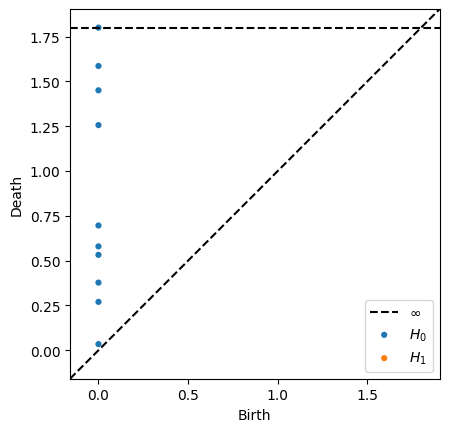

Every man is sick. The nurse is a man. The nurse is sick.
['every', 'man', 'is', 'sick', '.', 'the', 'nurse', 'is', 'a', 'man', '.', 'the', 'nurse', 'is', 'sick', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

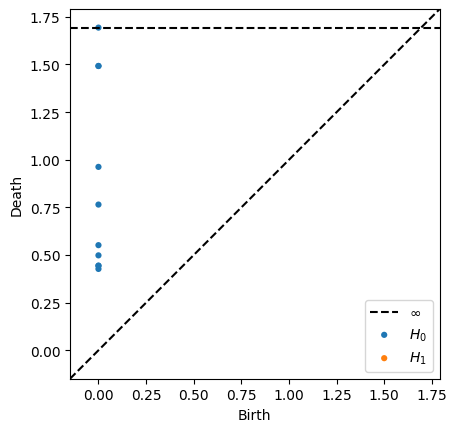

Every man is sick. The nurse is a man. The nurse is sick.
['every', 'man', 'is', 'sick', '.', 'the', 'nurse', 'is', 'a', 'man', '.', 'the', 'nurse', 'is', 'sick', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

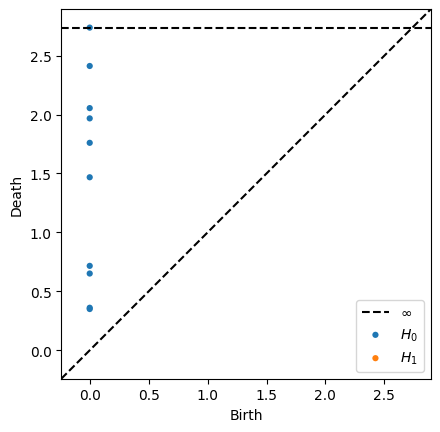

Every man is sick. The nurse is a man. The nurse is sick.
['every', 'man', 'is', 'sick', '.', 'the', 'nurse', 'is', 'a', 'man', '.', 'the', 'nurse', 'is', 'sick', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

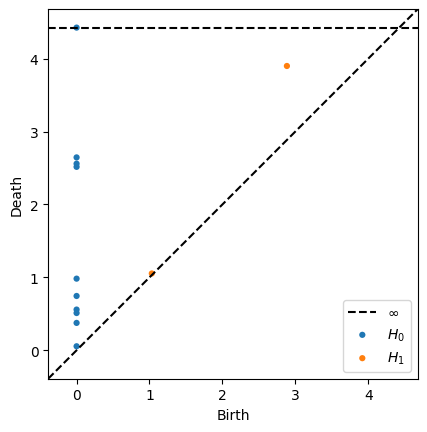

time: 1.41 s (started: 2021-02-01 21:51:03 +00:00)


In [ ]:
#syllogism  
argument='Every man is sick. The nurse is a man. The nurse is sick.'
display_argument(argument,random_vector50)
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

Every animal is created by evolution. The lion is an animal. The lion is created by evolution.
['every', 'animal', 'is', 'created', 'by', 'evolution', '.', 'the', 'lion', 'is', 'an', 'animal', '.', 'the', 'lion', 'is', 'created', 'by', 'evolution', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

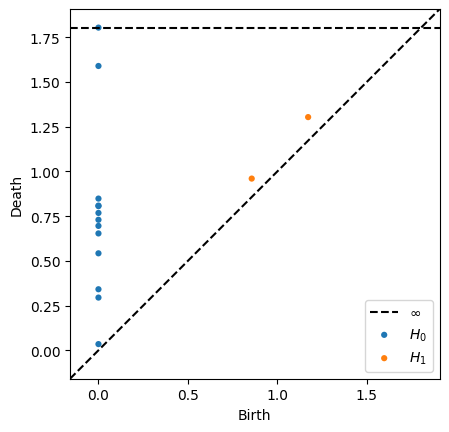

Every animal is created by evolution. The lion is an animal. The lion is created by evolution.
['every', 'animal', 'is', 'created', 'by', 'evolution', '.', 'the', 'lion', 'is', 'an', 'animal', '.', 'the', 'lion', 'is', 'created', 'by', 'evolution', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

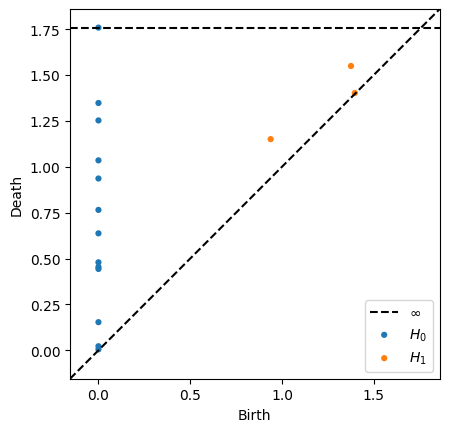

Every animal is created by evolution. The lion is an animal. The lion is created by evolution.
['every', 'animal', 'is', 'created', 'by', 'evolution', '.', 'the', 'lion', 'is', 'an', 'animal', '.', 'the', 'lion', 'is', 'created', 'by', 'evolution', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

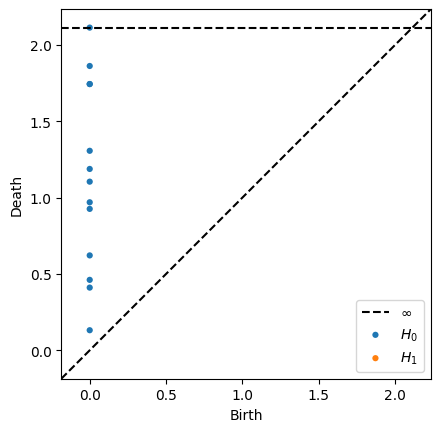

Every animal is created by evolution. The lion is an animal. The lion is created by evolution.
['every', 'animal', 'is', 'created', 'by', 'evolution', '.', 'the', 'lion', 'is', 'an', 'animal', '.', 'the', 'lion', 'is', 'created', 'by', 'evolution', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

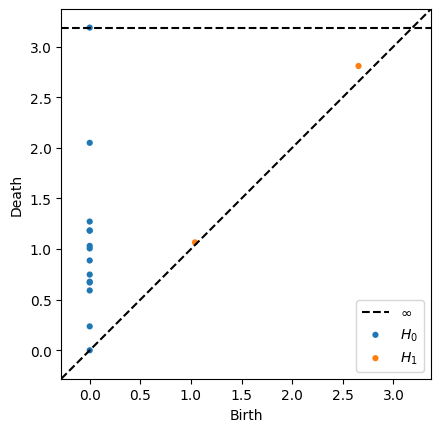

time: 1.27 s (started: 2021-02-01 22:03:40 +00:00)


In [ ]:
#syllogism  
argument='Every animal is created by evolution. The lion is an animal. The lion is created by evolution.'
display_argument(argument,random_vector50)
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

Every man is happy. The nurse is a man. The nurse is happy.
['every', 'man', 'is', 'happy', '.', 'the', 'nurse', 'is', 'a', 'man', '.', 'the', 'nurse', 'is', 'happy', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

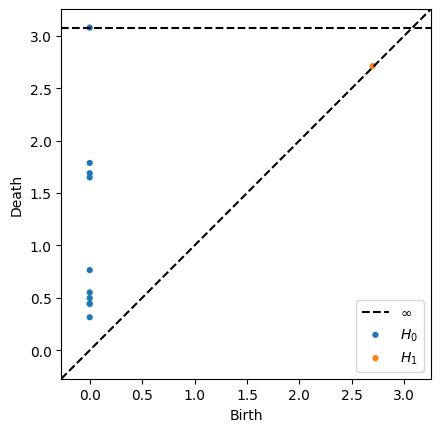

Every man is happy. The nurse is a man. The nurse is happy.
['every', 'man', 'is', 'happy', '.', 'the', 'nurse', 'is', 'a', 'man', '.', 'the', 'nurse', 'is', 'happy', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

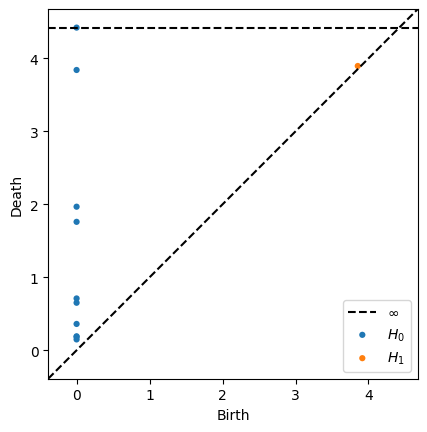

Every man is happy. The nurse is a man. The nurse is happy.
['every', 'man', 'is', 'happy', '.', 'the', 'nurse', 'is', 'a', 'man', '.', 'the', 'nurse', 'is', 'happy', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

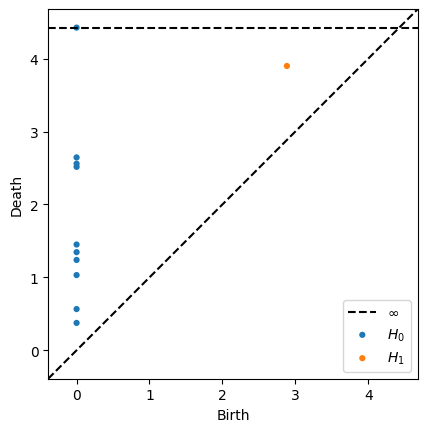

time: 1.03 s (started: 2021-02-01 21:52:41 +00:00)


In [ ]:
#syllogism  
argument='Every man is happy. The nurse is a man. The nurse is happy.'
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

Gold is going up. Platinum is also going up. We should buy all metals, including copper and silver.
['gold', 'is', 'going', 'up', '.', 'platinum', 'is', 'also', 'going', 'up', '.', 'we', 'should', 'buy', 'all', 'metals', ',', 'including', 'copper', 'and', 'silver', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

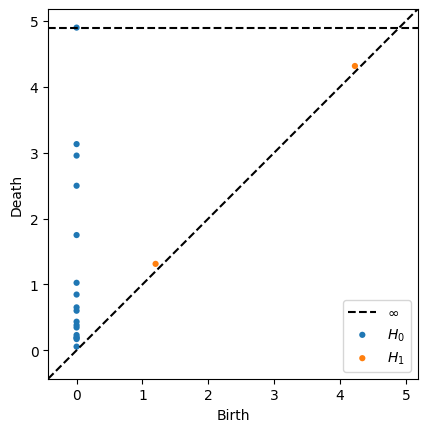

Gold is going up. Platinum is also going up. We should buy all metals, including copper and silver.
['gold', 'is', 'going', 'up', '.', 'platinum', 'is', 'also', 'going', 'up', '.', 'we', 'should', 'buy', 'all', 'metals', ',', 'including', 'copper', 'and', 'silver', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

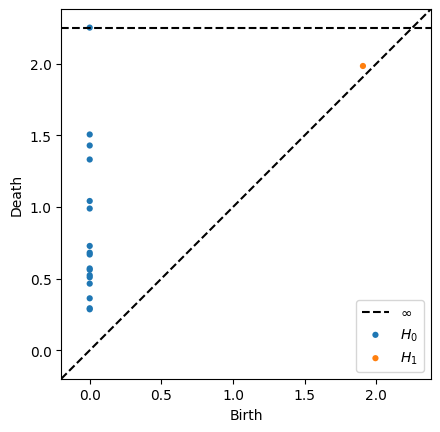

Gold is going up. Platinum is also going up. We should buy all metals, including copper and silver.
['gold', 'is', 'going', 'up', '.', 'platinum', 'is', 'also', 'going', 'up', '.', 'we', 'should', 'buy', 'all', 'metals', ',', 'including', 'copper', 'and', 'silver', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

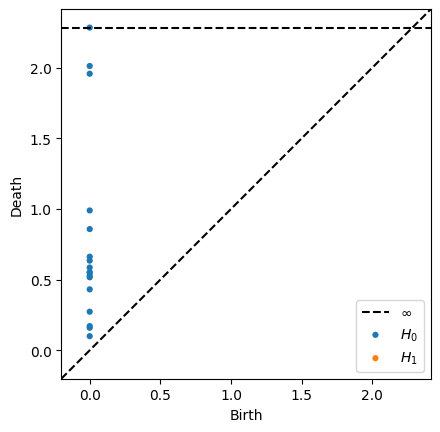

Gold is going up. Platinum is also going up. We should buy all metals, including copper and silver.
['gold', 'is', 'going', 'up', '.', 'platinum', 'is', 'also', 'going', 'up', '.', 'we', 'should', 'buy', 'all', 'metals', ',', 'including', 'copper', 'and', 'silver', '.']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

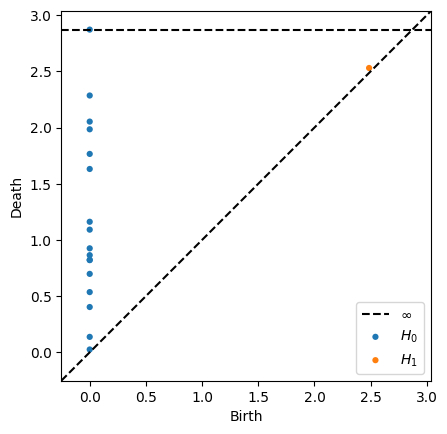

time: 1.48 s (started: 2021-02-01 22:06:35 +00:00)


In [ ]:
#induction 
argument='Gold is going up. Platinum is also going up. We should buy all metals, including copper and silver.'
display_argument(argument,random_vector50)
display_argument(argument,random_vector100)
display_argument(argument,random_vector200)
display_argument(argument,random_vector300)

In [ ]:
### HERE ###
""" 
def display_argument(sentences,vector):
  tokenized_sents = tokenizer.tokenize(sentences.lower()) 
  if len(vector)==100:
    glove_sents = glove_function(gloveModel100,tokenized_sents)
  if len(vector)==200:
    glove_sents = glove_function(gloveModel200, tokenized_sents)
  if len(vector)==300:
    glove_sents = glove_function(gloveModel300,tokenized_sents)
  print(sentences)
  print(tokenized_sents)
  te=np.transpose(takensEmbedding(t_series(glove_sents,vector),2,2))
  te=abs(te)
  diagrams = ripser(te, metric='euclidean')['dgms']
  plot_diagrams(diagrams, show=False)
  ImageName='i' + str(len(vector)) + 'tde_abs'+sentences+'.'+'png'
  plt.savefig(ImageName) 
  files.download(ImageName)
  plt.show()

"""
#--------------
def display_argument3(sentences,random_vector,delay,dimensions):
  tokenized_sents = tokenizer.tokenize(sentences.lower()) 
  if len(random_vector)==100:
    glove_sents = glove_function(gloveModel100,tokenized_sents)
  if len(random_vector)==200:
    glove_sents = glove_function(gloveModel200, tokenized_sents)
  if len(random_vector)==300:
    glove_sents = glove_function(gloveModel300,tokenized_sents)
  print(sentences)
  print(tokenized_sents)
  te=np.transpose(takensEmbedding(t_series(glove_sents,random_vector),delay,dimensions))
  te=abs(te)
  diagrams = ripser(te, metric='euclidean')['dgms']
  plot_diagrams(diagrams, show=True)
  ImageName='i'+ str(len(random_vector)) + 't_dim' +str(dimensions)+'t_del'+str(delay)+sentences+'.'+'png'
  plt.savefig(ImageName) 
  files.download(ImageName)
  plt.show()

In [ ]:
#syllogism  
argument='Every man is sick. The nurse is a man. The nurse is sick.'
display_argument3(argument,random_vector100 ,2,3)
display_argument3(argument,random_vector200 ,2,3)
display_argument3(argument,random_vector300 ,2,3)

In [ ]:
#syllogism  
argument='Every man is happy. The nurse is a man. The nurse is happy.'
display_argument3(argument,random_vector100 ,2,3)
display_argument3(argument,random_vector200 ,2,3)
display_argument3(argument,random_vector300 ,2,3)

In [ ]:
#syllogism  
argument='Every man is sick. The nurse is a man. The nurse is sick.'
display_argument3(argument,random_vector100 ,3,3)
display_argument3(argument,random_vector200 ,3,3)
display_argument3(argument,random_vector300 ,3,3)

In [ ]:
#syllogism  
argument='Every man is happy. The nurse is a man. The nurse is happy.'
display_argument3(argument,random_vector100 ,3,2)
display_argument3(argument,random_vector200 ,3,2)
display_argument3(argument,random_vector300 ,3,2)